In [26]:
from sklearn.metrics import (confusion_matrix, 
                             precision_score,
                             recall_score,
                             roc_auc_score,
                             RocCurveDisplay,
                             ConfusionMatrixDisplay,
                             PrecisionRecallDisplay)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.utils.class_weight import compute_sample_weight

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd
import numpy as np

from tqdm import trange, tqdm

import warnings
warnings.filterwarnings('ignore')

# Анализ датасета

In [27]:
df = pd.read_csv('diabetes.csv')
df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


In [28]:
df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


### Анализ пропущенных значений

In [29]:
df['smoking_history'] = df['smoking_history'].replace(['No Info'], np.NaN)

In [30]:
print(f'Количество объектов с пропущенными значениями: {df.isnull().any(axis = 1).sum()}') 

Количество объектов с пропущенными значениями: 35816


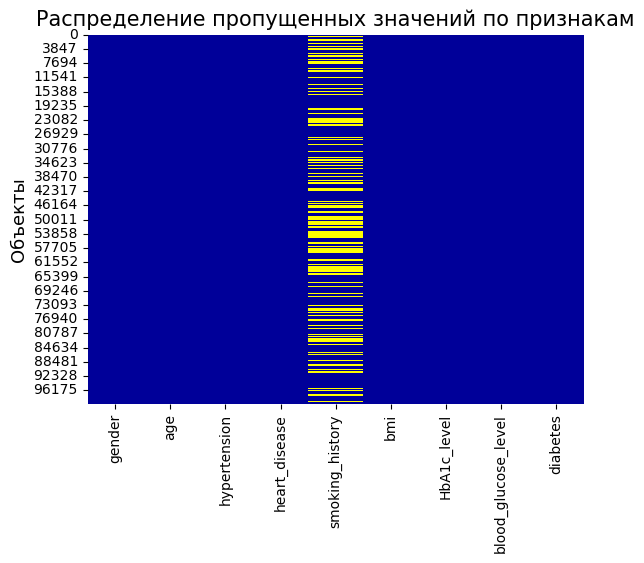

In [31]:
s = sns.heatmap(df.isnull(), cmap = sns.color_palette(['#000099', '#ffff00']), cbar = False)
s.set_ylabel('Объекты', fontsize = 13)
s.set_title('Распределение пропущенных значений по признакам', fontsize = 15)

plt.show()

In [32]:
mis = {}

for feature in df.columns:
    mis[feature] = np.mean(df[feature].isnull()) * 100

for feature, val in sorted(mis.items(), key = lambda item: item[1], reverse = True):
    print(f'{feature} - {np.mean(df[feature].isnull()) * 100:.2f}%')

smoking_history - 35.82%
gender - 0.00%
age - 0.00%
hypertension - 0.00%
heart_disease - 0.00%
bmi - 0.00%
HbA1c_level - 0.00%
blood_glucose_level - 0.00%
diabetes - 0.00%


In [33]:
df = df.dropna()

In [34]:
print(f'Количество объектов с пропущенными значениями: {df.isnull().any(axis = 1).sum()}') 

Количество объектов с пропущенными значениями: 0


### Перевод категориальных признаков в числовые

In [35]:
df = pd.concat([df.drop(['gender'], axis = 1), pd.get_dummies(df['gender'], dtype = int)], axis = 1)
df = pd.concat([df.drop(['smoking_history'], axis = 1), pd.get_dummies(df['smoking_history'], dtype = int)], axis = 1)

df

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,Female,Male,Other,current,ever,former,never,not current
0,80.0,0,1,25.19,6.6,140,0,1,0,0,0,0,0,1,0
2,28.0,0,0,27.32,5.7,158,0,0,1,0,0,0,0,1,0
3,36.0,0,0,23.45,5.0,155,0,1,0,0,1,0,0,0,0
4,76.0,1,1,20.14,4.8,155,0,0,1,0,1,0,0,0,0
5,20.0,0,0,27.32,6.6,85,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99992,26.0,0,0,34.34,6.5,160,0,1,0,0,0,0,0,1,0
99993,40.0,0,0,40.69,3.5,155,0,1,0,0,0,0,0,1,0
99997,66.0,0,0,27.83,5.7,155,0,0,1,0,0,0,1,0,0
99998,24.0,0,0,35.42,4.0,100,0,1,0,0,0,0,0,1,0


### Анализ выбросов

In [36]:
def show_boxplots(df, title = None):

    rows_cnt = int(np.ceil(len(df.columns) / 2))

    fig = plt.figure(layout = 'constrained', figsize = (10, 5))
    gs = GridSpec(rows_cnt, 2, figure = fig)

    for i, feature in enumerate(df.columns):
        ax = fig.add_subplot(gs[i // 2, i % 2])
        df.boxplot(column = feature, ax = ax)

    plt.suptitle(title, fontsize = 15)
    plt.show()

In [45]:
binary_features = np.array([col for col in df if np.isin(df[col].unique(), [0, 1]).all()])
binary_features

array(['hypertension', 'heart_disease', 'diabetes', 'Female', 'Male',
       'Other', 'current', 'ever', 'former', 'never', 'not current'],
      dtype='<U13')

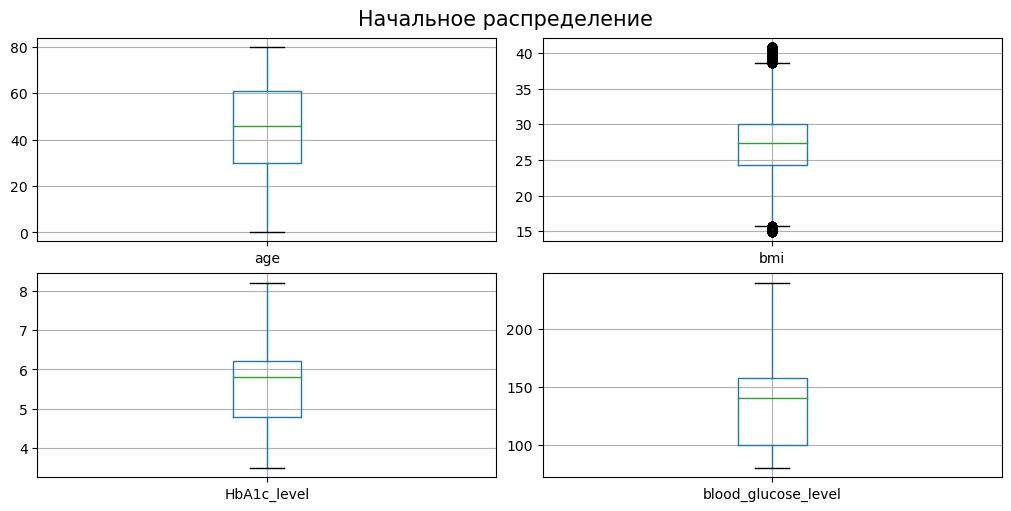

In [46]:
show_boxplots(df.drop(binary_features, axis = 1), title = 'Начальное распределение')

In [39]:
for feature in df.drop(binary_features, axis = 1).columns:

    df_sort = df[feature].sort_values()

    Q1 = df_sort.quantile(q = .25)
    Q3 = df_sort.quantile(q = .75)
    IQR = Q3 - Q1

    df = df[(df_sort >= Q1 - 1.5 * IQR) & (df_sort <= Q3 + 1.5 * IQR)]

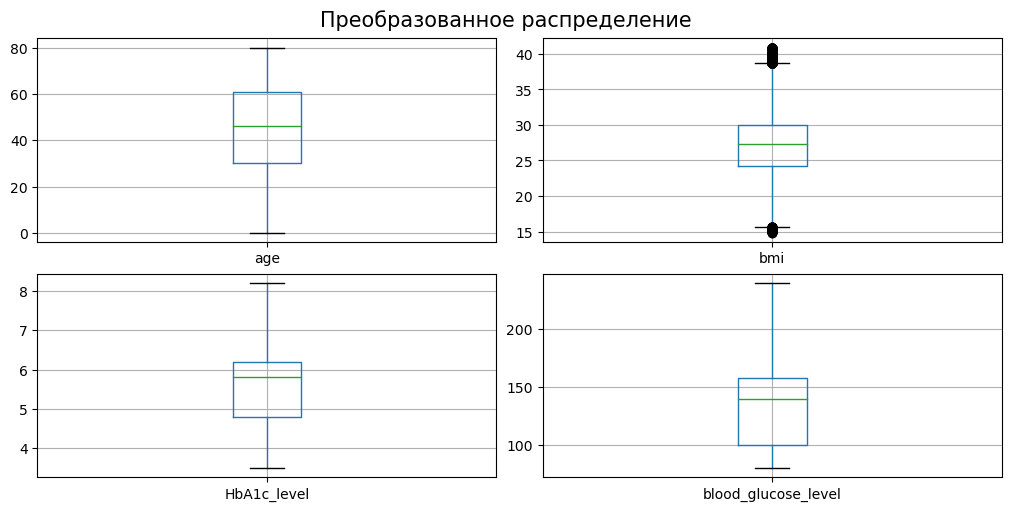

In [40]:
show_boxplots(df.drop(binary_features, axis = 1), title = 'Преобразованное распределение')

### Распределение классов

In [41]:
def make_annotations(plot):
    for p in plot.patches:
        plot.annotate(int(p.get_height()),
                    (p.get_x() + p.get_width() / 2., p.get_height()),  
                    ha = 'center', 
                    va = 'center', 
                    xytext = (0, 7), 
                    textcoords = 'offset points')

In [42]:
def classes_distr(df, title = None):
    plt.figure(figsize = (5, 5))
    plt.rc('xtick', labelsize = 10)

    plot = sns.countplot(x = 'diabetes', data = df, palette = ["#0101DF", "#DF0101"], edgecolor = 'black')
    make_annotations(plot)

    plt.title(title, fontsize = 15, pad = 20)

    plt.tight_layout()
    plt.show()

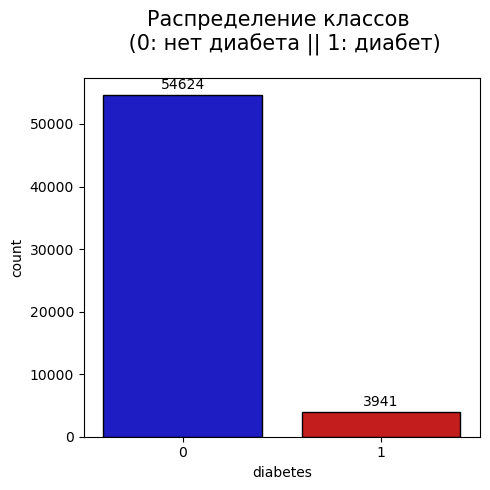

In [43]:
classes_distr(df, title = 'Распределение классов \n (0: нет диабета || 1: диабет)')

### Корреляция

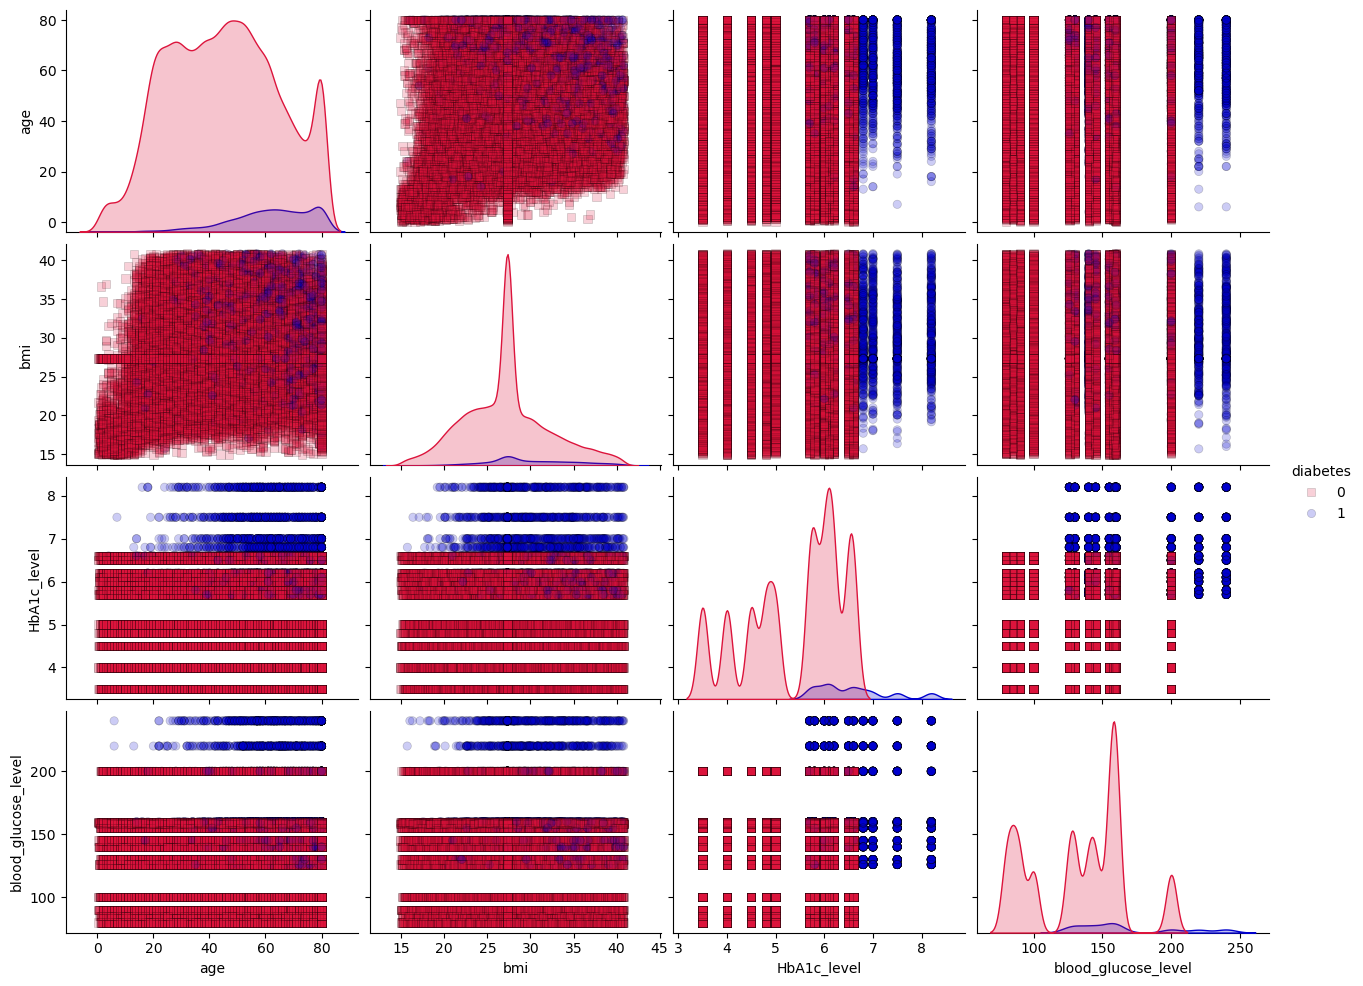

In [48]:
sns.pairplot(df.drop(binary_features[binary_features != 'diabetes'], axis = 1), 
             hue = 'diabetes',
             aspect = 1.3,
             plot_kws = {'edgecolor' : 'black', 'alpha': .2},
             palette = ['#DC143C', '#0000CD'],
             markers = ['s', 'o'])

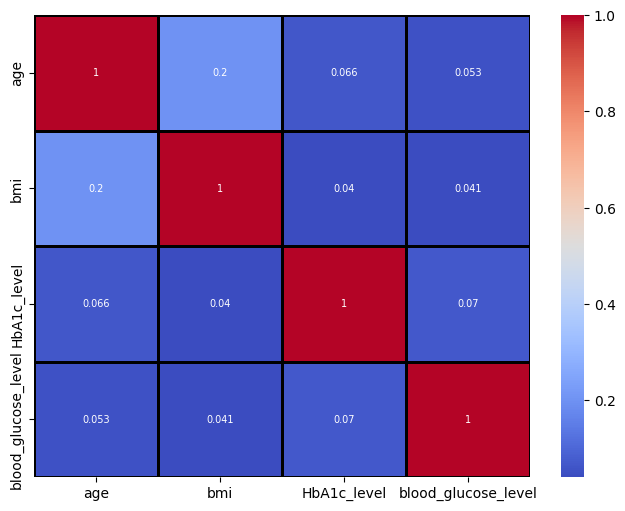

In [19]:
plt.figure(figsize = (8, 6))

sns.heatmap(df.drop(binary_features, axis = 1).corr(), 
            cmap = 'coolwarm', 
            linewidths = 2, 
            linecolor = 'black', 
            annot = True,
            annot_kws = {"fontsize" : 7})

plt.show()

# Задание 1

### Разделение на train и test

In [20]:
no_diabetes = df[df['diabetes'] == 0]
diabetes = df[df['diabetes'] == 1]

In [21]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    no_diabetes.drop(['diabetes'], axis = 1), no_diabetes['diabetes'], test_size = .2)

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    diabetes.drop(['diabetes'], axis = 1), diabetes['diabetes'], test_size = .1)

In [22]:
X_train = pd.concat([X_train1, X_train2]).sample(frac = 1)
X_test  = pd.concat([X_test1, X_test2]).sample(frac = 1)

y_train = pd.concat([y_train1, y_train2]).sample(frac = 1)
y_test = pd.concat([y_test1, y_test2]).sample(frac = 1)

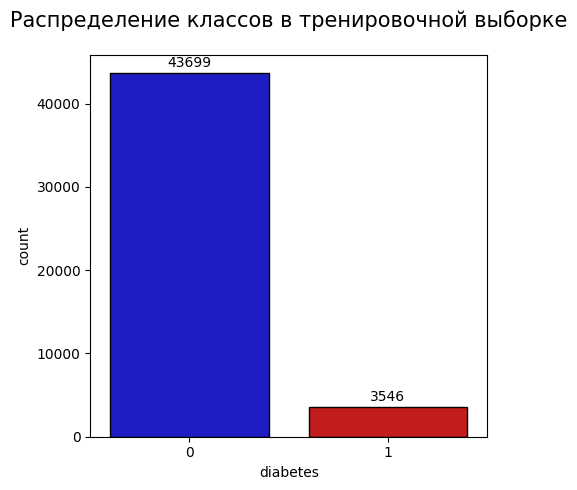

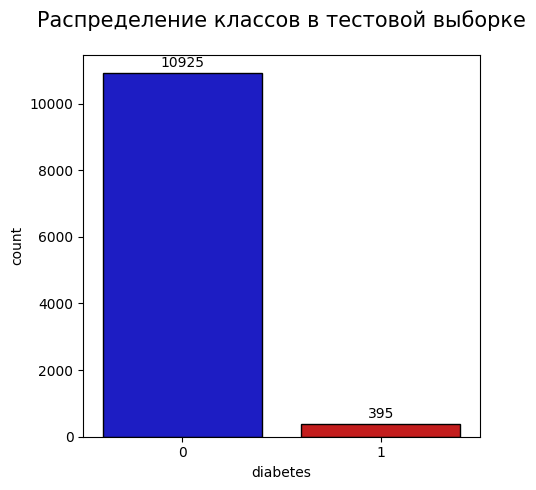

In [23]:
classes_distr(pd.DataFrame(y_train), title = 'Распределение классов в тренировочной выборке')
classes_distr(pd.DataFrame(y_test), title = 'Распределение классов в тестовой выборке')

### Классификация

In [24]:
weights = compute_sample_weight(class_weight = 'balanced', y = y_train)
np.unique(weights)

array([0.54057301, 6.66173153])

In [25]:
estimator = GradientBoostingClassifier().fit(X_train, y_train)
estimator_weights = GradientBoostingClassifier().fit(X_train, y_train, sample_weight = weights)

y_pred = estimator.predict(X_test)
y_pred_weights = estimator_weights.predict(X_test)

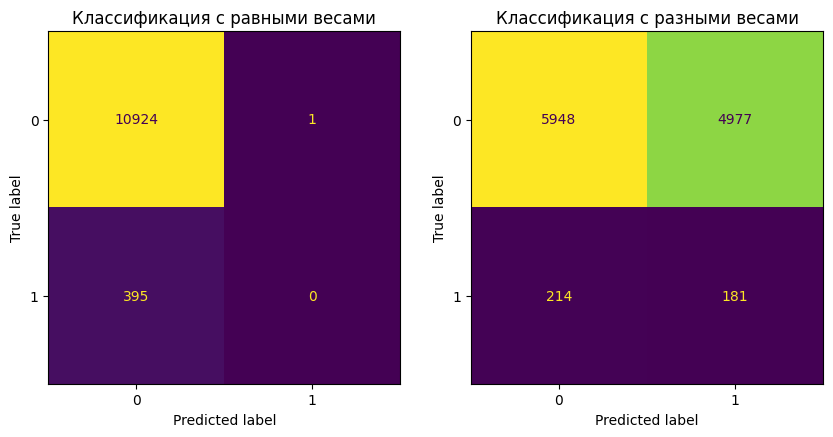

In [26]:
fig, ax = plt.subplots(1, 2, figsize = (10, 6))

ConfusionMatrixDisplay.from_estimator(estimator, X_test, y_test, colorbar = False, ax = ax[0])
ConfusionMatrixDisplay.from_estimator(estimator_weights, X_test, y_test, colorbar = False, ax = ax[1])

ax[0].set_title('Классификация с равными весами')
ax[1].set_title('Классификация с разными весами')

plt.show()

# Задание 2

In [27]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

precision = precision_score(y_test, y_pred) * 100
recall = recall_score(y_test, y_pred) * 100
specificity = tn / (tn + fp) * 100

In [28]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_weights).ravel()

precision_weights = precision_score(y_test, y_pred_weights) * 100
recall_weights = recall_score(y_test, y_pred_weights) * 100
specificity_weights = tn / (tn + fp) * 100

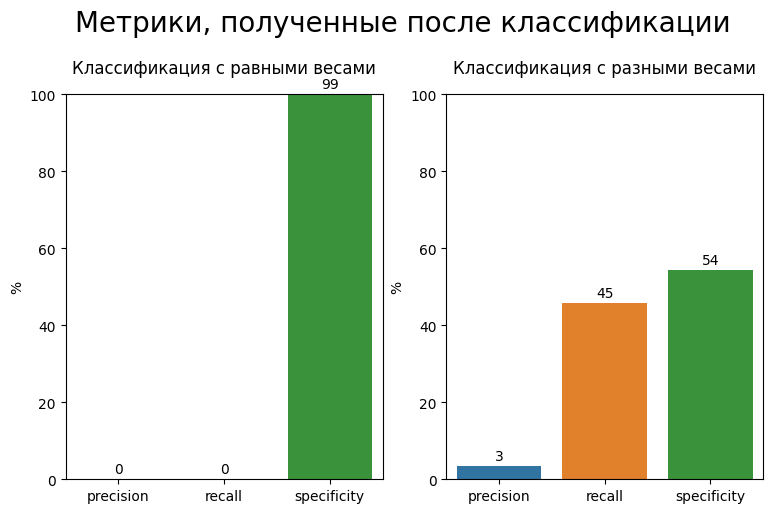

In [29]:
data = dict(x = ['precision', 'recall', 'specificity'], 
            y = [precision, recall, specificity])

data_weights = dict(x = ['precision', 'recall', 'specificity'], 
                    y = [precision_weights, recall_weights, specificity_weights])

data = pd.DataFrame(data)
data_weights = pd.DataFrame(data_weights)

fig, ax = plt.subplots(1, 2, figsize = (9, 5))
plt.rc('xtick', labelsize = 10)

plot = sns.barplot(x = 'x', y = 'y', data = data, ax = ax[0])
plot_weights = sns.barplot(x = 'x', y = 'y', data = data_weights, ax = ax[1])

make_annotations(plot)
make_annotations(plot_weights)

ax[0].set_ylim([0, 100])
ax[1].set_ylim([0, 100])

ax[0].set_xlabel('')
ax[0].set_ylabel('%')

ax[1].set_xlabel('')
ax[1].set_ylabel('%')

ax[0].set_title('Классификация с равными весами', pad = 15)
ax[1].set_title('Классификация с разными весами', pad = 15)

plt.suptitle('Метрики, полученные после классификации', fontsize = 20, y = 1.05)
plt.show()

# Задание 3

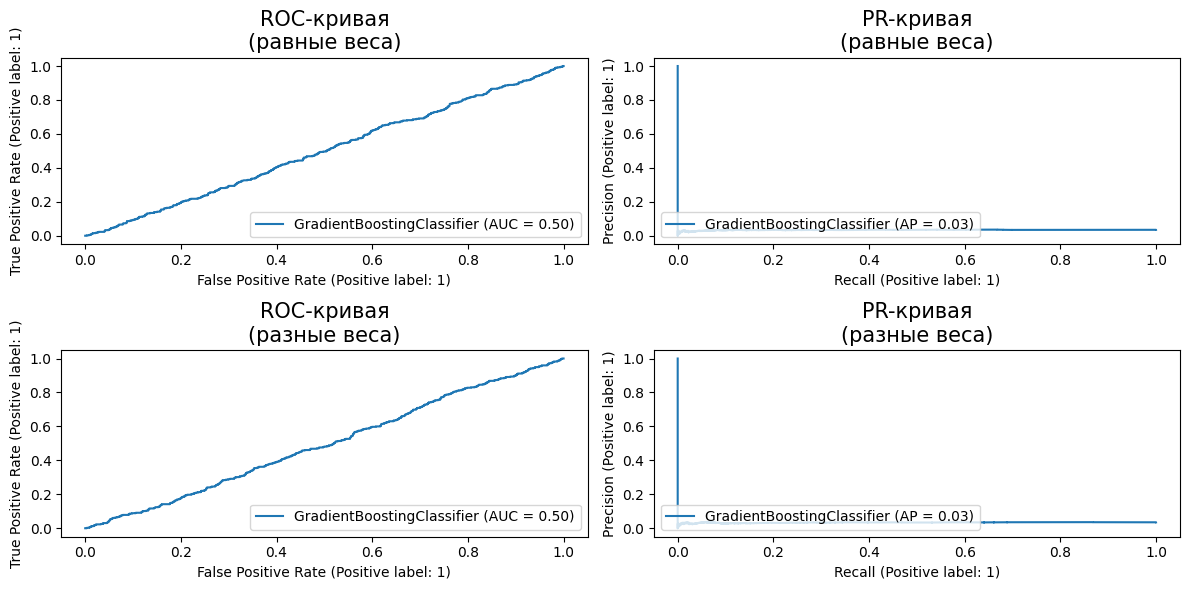

In [30]:
fig, ax = plt.subplots(2, 2, figsize = (12, 6))

RocCurveDisplay.from_estimator(estimator, X_test, y_test, ax = ax[0][0])
PrecisionRecallDisplay.from_estimator(estimator, X_test, y_test, ax = ax[0][1])

RocCurveDisplay.from_estimator(estimator_weights, X_test, y_test, ax = ax[1][0])
PrecisionRecallDisplay.from_estimator(estimator_weights, X_test, y_test, ax = ax[1][1])

ax[0][0].set_title('ROC-кривая\n(равные веса)', fontsize = 15)
ax[0][1].set_title('PR-кривая\n(равные веса)', fontsize = 15)

ax[1][0].set_title('ROC-кривая\n(разные веса)', fontsize = 15)
ax[1][1].set_title('PR-кривая\n(разные веса)', fontsize = 15)

plt.tight_layout()
plt.show()

# Задание 4

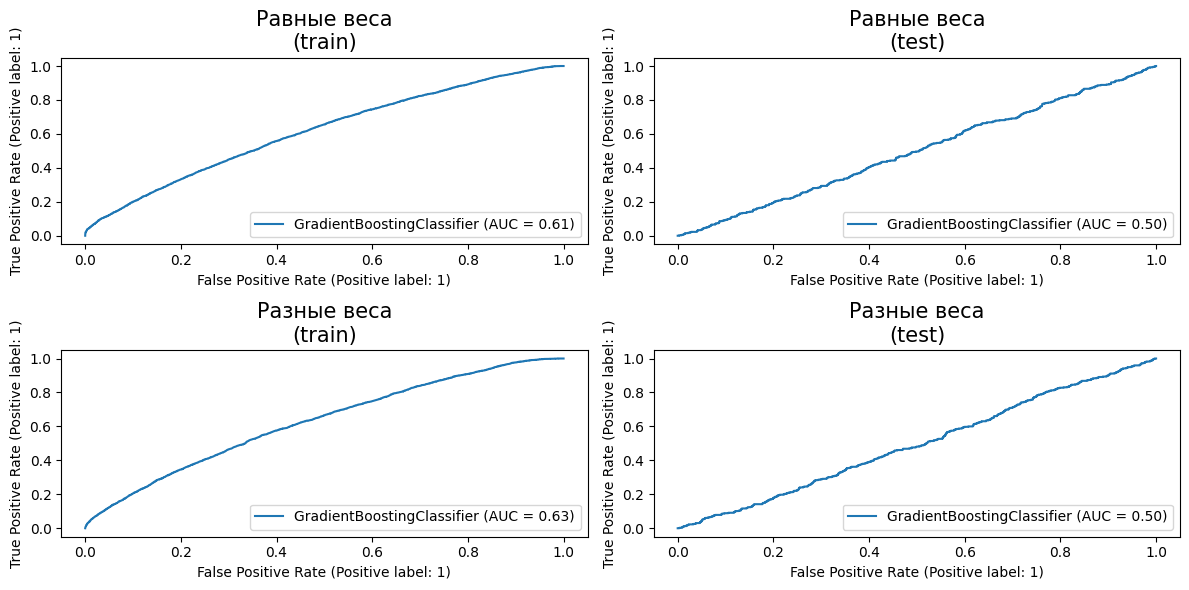

In [31]:
fig, ax = plt.subplots(2, 2, figsize = (12, 6))

RocCurveDisplay.from_estimator(estimator, X_train, y_train, ax = ax[0][0])
RocCurveDisplay.from_estimator(estimator, X_test, y_test, ax = ax[0][1])

RocCurveDisplay.from_estimator(estimator_weights, X_train, y_train, ax = ax[1][0])
RocCurveDisplay.from_estimator(estimator_weights, X_test, y_test, ax = ax[1][1])

ax[0][0].set_title('Равные веса\n(train)', fontsize = 15)
ax[0][1].set_title('Равные веса\n(test)', fontsize = 15)

ax[1][0].set_title('Разные веса\n(train)', fontsize = 15)
ax[1][1].set_title('Разные веса\n(test)', fontsize = 15)

plt.tight_layout()
plt.show()

# Задание 5

In [36]:
def show_dependency(x, y1, y2, xlabel = None, ylabel = None, title = None, label1 = None, label2 = None):
    plt.figure(figsize = (10, 4))

    plt.plot(x, y1, linewidth = 2, label = label1)
    plt.plot(x, y2, linewidth = 2, label = label2)

    plt.xlabel(xlabel) 
    plt.ylabel(ylabel)

    plt.yticks(range(0, 101, 10))

    plt.title(title)

    plt.legend()
    plt.grid()

    plt.show()    

In [33]:
ada_boost_aucs = []
grad_boost_aucs = []

for n_estimators in trange(50, 150):

    ada_boost = AdaBoostClassifier(n_estimators = n_estimators).fit(X_train, y_train, sample_weight = weights)
    grad_boost = GradientBoostingClassifier(n_estimators = n_estimators).fit(X_train, y_train, sample_weight = weights)

    ada_boost_aucs.append(roc_auc_score(y_test, ada_boost.predict(X_test)) * 100)
    grad_boost_aucs.append(roc_auc_score(y_test, grad_boost.predict(X_test)) * 100)

100%|██████████| 100/100 [21:13<00:00, 12.74s/it]


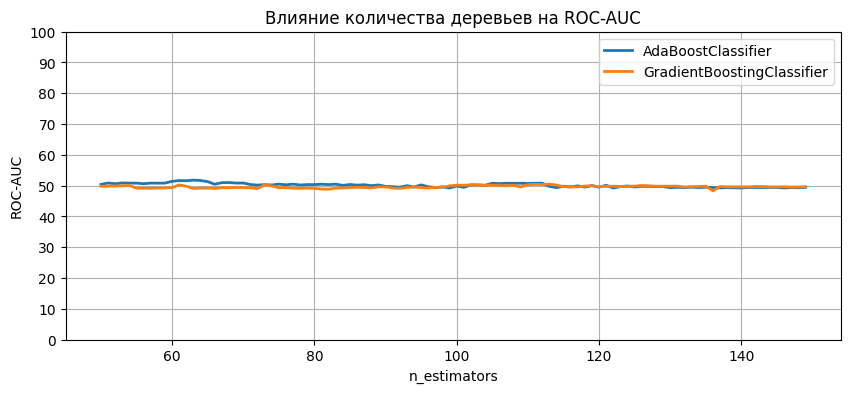

In [37]:
show_dependency(range(50, 150), ada_boost_aucs, grad_boost_aucs, title = 'Влияние количества деревьев на ROC-AUC',
                xlabel = 'n_estimators', ylabel = 'ROC-AUC', 
                label1 = 'AdaBoostClassifier', label2 = 'GradientBoostingClassifier')

In [38]:
ada_boost_aucs = []
grad_boost_aucs = []

for learning_rate in tqdm(np.arange(0.01, 1, 0.05)):

    ada_boost = AdaBoostClassifier(learning_rate  = learning_rate).fit(X_train, y_train, sample_weight = weights)
    grad_boost = GradientBoostingClassifier(learning_rate  = learning_rate).fit(X_train, y_train, sample_weight = weights)

    ada_boost_aucs.append(roc_auc_score(y_test, ada_boost.predict(X_test)) * 100)
    grad_boost_aucs.append(roc_auc_score(y_test, grad_boost.predict(X_test)) * 100)

100%|██████████| 20/20 [02:58<00:00,  8.91s/it]


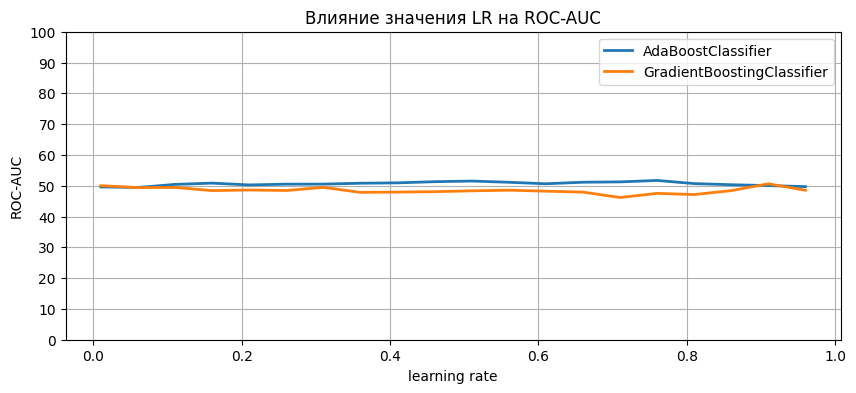

In [41]:
show_dependency(np.arange(0.01, 1, 0.05), ada_boost_aucs, grad_boost_aucs, title = 'Влияние значения LR на ROC-AUC',
                xlabel = 'learning rate', ylabel = 'ROC-AUC',
                label1 = 'AdaBoostClassifier', label2 = 'GradientBoostingClassifier')